<h1><center> Study: ER and NR Discrimination </center></h1>

Last Modified: By Daniel Baur on 13th May 2020

This jupyter notebook is used to conduct the ER and NR discrimination study utilizing NESTv2.1.

### Table of Contents


0. **[Stuff](#0.-Stuff)**<br>
    0.1 [Imports](#0.1-Imports)<br>
    0.2 [Definitions](#0.2-Definitions)<br>


1. **[Detector Parameter Space](#1.-Detector-Parameter-Space)**<br>
    1.0 [Definitions](#1.0-Definitions)<br>
    1.1 [Default Parameters](#1.2-Default-Parameters)<br>
    1.2 [Parameter Sweep](#1.2-Parameter-Sweep)<br>
    1.3 [Printing Parameter Values](#1.3-Printing-Parameter-Values)<br>
    1.4 [Generating Detector Files](#1.4-Generating-Detector-Files)<br>
    1.5 [Determining the Spectra Boundaries](1.5-Determining-the-Spectra-Boundaries)<br>


2. **[Input Spectra](#2.-Input-Spectra)**<br>
    2.0 [General Definitions](#2.0-General-Definitions)<br>
    2.1 [ER Background](#2.1-ER-Background)<br>
    2.2 [WIMPs](#2.2-WIMPs)<br>


3. **[Generating Data](#3.-Data-Generation)**<br>


4. **[Analysis](#4.-Analysis)**<br>
    4.0 [Investigations in Advance](#4.0-Investigations-in-Advance)<br>
    4.1 [Looping over Populations](#4.1-Looping-over-Populations)<br>



# 0. Stuff

## 0.1 Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('file://' +"/home/daniel/Desktop/arbeitsstuff/miscellaneous_figures/danielsmplstyle.mplstyle")
import numpy as np
from scipy import stats
from scipy.special import binom as binomcoeff
from scipy.optimize import curve_fit
from scipy.integrate import quad
import datetime
import pprint
import itertools
import math
import os
from matplotlib.ticker import AutoMinorLocator
import subprocess
import json

# including the SFS libraries
import sys
sys.path.append("./../../") 
import SF
import SF_spectrum
import SF_detector
import SF_process
import SF_nestcom

## 0.2 Definitions

In [2]:

# formatting
uni_blue = '#004A9B'
uni_red = '#C1002A'
color_ers = uni_red
color_nrs = uni_blue

# paths
path_data = "./data/"
path_signatures = path_data +"signatures/"
path_popdata = path_data +"popdata/"
path_input = "./input/"
path_output = "./output/"
path_output_poplots = path_output +"poplots/"
path_spectra = path_data +"spectra/"
path_detectors = path_data +"detectors/"
path_presentation = "/home/daniel/Desktop/arbeitsstuff/20200519__wg4_meeting_talk__sfs/images/"
name_simdata = "simdata"
name_summarized_data = "summarized_data"


### flags
flag_delete_data = True
# detectors and spectra
flag_generate_detectors = True
flag_print_detector_parameters_texhtml = True
flag_test_spectrum_boundaries = True
flag_generate_erbkg_recoil_spectra = True
flag_generate_wimp_recoil_spectra = True
flag_plot_wimp_recoil_spectra = True
flag_plot_spectra = True
# raw data generation
flag_generate_raw_data = True
# analysis
flag_analysis_loop = True
flag_analysis_comparative = True


## 0.3 Preparations

In [3]:
if flag_delete_data == True:
    subprocess.call("rm -r ./data/spectra/*", shell=True)
    subprocess.call("rm -r ./data/detectors/*", shell=True)
    subprocess.call("rm -r ./data/signatures/*", shell=True)
    subprocess.call("rm -r ./data/popdata/*", shell=True)


# 1. Detector Parameter Space

## 1.0 Definitions

In [4]:
detector_filename = ""

paramrange_edrift = [250, 500, 750, 1000] # in V/cm

## 1.1 Default Parameters

In [5]:

# default dictionary
default_detector_parameters = {
    "g1" : 0.119, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.38, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 0.90, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.22, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 3, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 494, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : 0.102, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 100., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 10.85, # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 1600., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 175, # for liquid drift speed calculation
    "p_bar" : 2., # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 822., # center of detector for S1 corrections, in usec.
    "dt_min" : 75.8, # minimum. Top of detector fiducial volume
    "dt_max" : 1536.5, # maximum. Bottom of detector fiducial volume
    "radius" : 1300., # millimeters (fiducial rad)
    "radmax" : 1350., # actual physical geo. limit
    "TopDrift" : 3005., # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 3012.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 3000., # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 250, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 30., # baseline unc in mm, see NEST.cpp for usage
}


## 1.2 Parameter Sweep

In [6]:
# parameter space dictionary
darwin_detector_parameter_space = {
    "g1" : [0.11, 0.13, 0.15, 0.17],
    "eLife_us" : [1500, 1750, 2000, 2250], # 
}


## 1.3 Printing Parameter Values

In [7]:
if flag_print_detector_parameters_texhtml == True:
    
    input_string_default = """
    "g1" : 0.073, # phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect
    "sPEres" : 0.58, # single phe resolution (Gaussian assumed)
    "sPEthr" : 0.35, # POD threshold in phe, usually used IN PLACE of sPEeff
    "sPEeff" : 1.00, # actual efficiency, can be used in lieu of POD threshold
    "noise_0_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "noise_1_" : 0.0, # baseline noise mean and width in PE (Gaussian)
    "P_dphe" : 0.2, # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT
    "coinWind" : 100, # S1 coincidence window in ns
    "coinLevel" : 2, # how many PMTs have to fire for an S1 to count
    "numPMTs" : 89, # For coincidence calculation
    # Linear noise" terms as defined in Dahl thesis and by D. McK
    "noise_2_" : 3e-2, # S1 -> S1 Gaussian-smeared with noise[2]*S1
    "noise_3_" : 3e-2, # S2 -> S2 Gaussian-smeared with noise[3]*S2
    # Ionization and Secondary Scintillation (S2) parameters
    "g1_gas" : .0655, # phd per S2 photon in gas, used to get SE size
    "s2Fano" : 3.61, # Fano-like fudge factor for SE width
    "s2_thr" : 300., # the S2 threshold in phe or PE, *not* phd. Affects NR most
    "E_gas" : 12., # field in kV/cm between liquid/gas border and anode
    "eLife_us" : 2200., # the drift electron mean lifetime in micro-seconds
    # Thermodynamic Properties  [if you are getting warnings about being in gas, lower T and/or raise p]
    "inGas" : False, # 
    "T_Kelvin" : 177., # for liquid drift speed calculation
    "p_bar" : 2.14, # gas pressure in units of bars, it controls S2 size
    # Data Analysis Parameters and Geometry
    "dtCntr" : 40., # center of detector for S1 corrections, in usec.
    "dt_min" : 20., # minimum. Top of detector fiducial volume
    "dt_max" : 60., # maximum. Bottom of detector fiducial volume
    "radius" : 50., # millimeters (fiducial rad)
    "radmax" : 50., # actual physical geo. limit
    "TopDrift" : 150., # mm not cm or us (but, this *is* where dt=0), a z-axis value of 0 means the bottom of the detector (cathode OR bottom PMTs), In 2-phase, TopDrift=liquid/gas border. In gas detector it's GATE, not anode!
    "anode" : 152.5, # the level of the anode grid-wire plane in mm, In a gas TPC, this is not TopDrift (top of drift region), but a few mm, above it
    "gate" : 147.5, # mm. This is where the E-field changes (higher), in gas detectors, the gate is still the gate, but it's where S2 starts
    "cathode" : 1.00, # mm. Defines point below which events are gamma-X
    # 2-D (X & Y) Position Reconstruction
    "PosResExp" : 0.015, # exp increase in pos recon res at hi r, 1/mm
    "PosResBase" : 70.8364, # baseline unc in mm, see NEST.cpp for usage
    """
    
    input_string_sweep = """
    "g1" : [0.11, 0.13], # 0.15, 0.17],
    "eLife_us" : [2200, 2300], 
    """
    
    print("default detector parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_default, input_string_format="default_parameters", output_format="html")
    print("\n")
    print("sweep parameters, html:")
    SF_detector.print_detector_parameters(input_string=input_string_sweep, input_string_format="parameter_sweep", output_format="html")
    print("\n")


default detector parameters, html:
| ''g1'' | 0.073 | phd per S1 phot at dtCntr (not phe). Divide out 2-PE effect |
| ''sPEres'' | 0.58 | single phe resolution (Gaussian assumed) |
| ''sPEthr'' | 0.35 | POD threshold in phe, usually used IN PLACE of sPEeff |
| ''sPEeff'' | 1.00 | actual efficiency, can be used in lieu of POD threshold |
| ''noise_0_'' | 0.0 | baseline noise mean and width in PE (Gaussian) |
| ''noise_1_'' | 0.0 | baseline noise mean and width in PE (Gaussian) |
| ''P_dphe'' | 0.2 | chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT |
| ''coinWind'' | 100 | S1 coincidence window in ns |
| ''coinLevel'' | 2 | how many PMTs have to fire for an S1 to count |
| ''numPMTs'' | 89 | For coincidence calculation |
^ Linear noise" terms as defined in Dahl thesis and by D. McK ^^^
| ''noise_2_'' | 3e-2 | S1 -> S1 Gaussian-smeared with noise[2]*S1 |
| ''noise_3_'' | 3e-2 | S2 -> S2 Gaussian-smeared with noise[3]*S2 |
^ Ionization and Secondary Scintillation (S2) parameters ^

## 1.4 Generating Detector Files

#### Calculating the parameter space

'parameter_sweep_dictionaries':<br>The keys of this dictionary is a string which contains the deviations from the default detector parameters and the corresponding value is another dictionary containing the whole detector parameters. This dictionary is being looped over when the signature data is being generated:<br>
  (key,val) = (`string_with_deviations_from_default_detector`, `dictionary_with_all_detector_parameters`)

In [8]:
parameter_sweep_dictionaries = {} # this dictionary will contain all detector settings


# computing the cartesion product of the detector parameter space
cartesian_list = {} # from this list the 'update_dicts' will be generated
ctr = 0
for key in darwin_detector_parameter_space.keys():
    cartesian_list.update({key:[]})
    for i in range(len(darwin_detector_parameter_space[key])):
        cartesian_list[key].append([key, darwin_detector_parameter_space[key][i]])
        ctr += 1
parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))


# generating one dictionary containing all the detector parameters including the 
for i in range(len(parameters_cartesian_product)):
    update_param_dict = {parameters_cartesian_product[i][j][0]:parameters_cartesian_product[i][j][1] for j in range(len(parameters_cartesian_product[i]))}
    dictname = ""
    for key in sorted([*update_param_dict]):
        dictname = dictname +key +"_" +SF_detector.numberstring(number_int_float_or_string=update_param_dict[key]) +"_"
    if dictname.endswith("_") :
        dictname = dictname[:-1]
    #update_param_dict = default_detector_parameters.copy().update(**update_param_dict)
    update_param_dict_full = default_detector_parameters.copy()
    update_param_dict_full.update(**update_param_dict)
    parameter_sweep_dictionaries.update({dictname: update_param_dict_full})


# printing the various detector parameter dictionaries that 
flag_print_parameter_sweep_dictionaries = True
if flag_print_parameter_sweep_dictionaries == True:
    for key, val in parameter_sweep_dictionaries.items():
        print(key)
        for k, v in parameter_sweep_dictionaries[key].items():
            print("   ", k, ": ", parameter_sweep_dictionaries[key][k])
        print("")


eLife_us_1500_g1_0_11
    g1 :  0.11
    sPEres :  0.38
    sPEthr :  0.35
    sPEeff :  0.9
    noise_0_ :  0.0
    noise_1_ :  0.0
    P_dphe :  0.22
    coinWind :  100
    coinLevel :  3
    numPMTs :  494
    noise_2_ :  0.03
    noise_3_ :  0.03
    g1_gas :  0.102
    s2Fano :  3.61
    s2_thr :  100.0
    E_gas :  10.85
    eLife_us :  1500
    inGas :  False
    T_Kelvin :  175
    p_bar :  2.0
    dtCntr :  822.0
    dt_min :  75.8
    dt_max :  1536.5
    radius :  1300.0
    radmax :  1350.0
    TopDrift :  3005.0
    anode :  3012.5
    gate :  3000.0
    cathode :  250
    PosResExp :  0.015
    PosResBase :  30.0

eLife_us_1750_g1_0_11
    g1 :  0.11
    sPEres :  0.38
    sPEthr :  0.35
    sPEeff :  0.9
    noise_0_ :  0.0
    noise_1_ :  0.0
    P_dphe :  0.22
    coinWind :  100
    coinLevel :  3
    numPMTs :  494
    noise_2_ :  0.03
    noise_3_ :  0.03
    g1_gas :  0.102
    s2Fano :  3.61
    s2_thr :  100.0
    E_gas :  10.85
    eLife_us :  1750
    inGas : 

generating the detector files

In [9]:

# looping over all detector configurations
for key, val in parameter_sweep_dictionaries.items():

    # generating the detector header file with the current parameters
    SF_detector.gen_detector_hh_file_from_dict(
        detectorname=detector_filename +key,
        templatefilestring="./../../data/sample_detectors/" +SF.detector_templatefilename,
        savefolders = ["./data/detectors/"],
        **parameter_sweep_dictionaries[key]
    )



SF_detector: generating eLife_us_1500_g1_0_11.hh.
SF_detector: reading ./../../data/sample_detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detectors/eLife_us_1500_g1_0_11.hh
SF_detector: generating eLife_us_1750_g1_0_11.hh.
SF_detector: reading ./../../data/sample_detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detectors/eLife_us_1750_g1_0_11.hh
SF_detector: generating eLife_us_2000_g1_0_11.hh.
SF_detector: reading ./../../data/sample_detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detectors/eLife_us_2000_g1_0_11.hh
SF_detector: generating eLife_us_2250_g1_0_11.hh.
SF_detector: reading ./../../data/sample_detectors/DetectorExample_XENON10.hh
SF_detector: modifying the template .hh file.
SF_detector: saved ./data/detectors/eLife_us_2250_g1_0_11.hh
SF_detector: generating eLife_us_1500_g1_0_13.hh.
SF_detecto

## 1.5 Determining the Spectra Boundaries

This cell is used to calculate the boundaries (i.e. the maximum recoil energies) for the ER and NR spectra. Hereby it has to be ensured that the maximum NR energy of interest (i.e. ~40keV) yields an S1 that still lies within the examined observable space and that truncating this observable space does not affect the shape of the signatures within it.

In [10]:

if flag_test_spectrum_boundaries == True:
    
    test_spectrum_boundaries_name = "test_spectrum_boundaries"
    test_spectrum_boundaries_g1 = 0.17
    test_spectrum_boundaries_edepmax = 60 # 16
    test_spectrum_boundaries_it = "NR" # "ER"

    # generating the spectrum
    SF_spectrum.gen_gnampfino_parametersweep(
        name = test_spectrum_boundaries_name,
        savefolder = path_spectra,
        number_of_samples_per_run = 10000,
        paramrange_interactiontype = [test_spectrum_boundaries_it],
        paramrange_energydeposition = [test_spectrum_boundaries_edepmax],
        paramrange_edrift = [200]
    )

    # running NEST generating the data
    SF_nestcom.SF_nestcom_runnest(
        filestring_spectrum = path_spectra +test_spectrum_boundaries_name +".npy",
        pathstring_output = path_signatures,
        detectorname = "dummydetector",
        output_pre_string = "test_spectrum_simdata"
    )

    # processing the raw data
    test_spectrum_boundaries_processed_data = SF_process.gen_summarized_ndarray(
        input_folder = path_signatures,
        ndarray = "test_spectrum_simdata__" +test_spectrum_boundaries_name +"__dummydetector.npy",
        output_folder = path_output
    )

    print(f"mean cS1/g1 (e_dep={test_spectrum_boundaries_edepmax}keV_{test_spectrum_boundaries_it}): {test_spectrum_boundaries_processed_data['mean_s1_phe']/test_spectrum_boundaries_g1}")
    print(f"with 1sigma spread: {test_spectrum_boundaries_processed_data['mean_s1_phe_sigma']/test_spectrum_boundaries_g1}")

SF_spectrum: saved ndarray 'test_spectrum_boundaries.npy' to './data/spectra/'
#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_10000__INTERACTION_NR__ENERGY_60_0__EDRIFT_200_0
SF_nestcom_runnest: successfully ran EVENTS_10000__INTERACTION_NR__ENERGY_60_0__EDRIFT_200_0
SF_nestcom_runnest: saved EVENTS_10000__INTERACTION_NR__ENERGY_60_0__EDRIFT_200_0
SF_nestcom_runnest: generating test_spectrum_simdata__test_spectrum_boundaries__dummydetector.npy
SF_nestcom_runnest: generated concatenated array test_spectrum_simdata__test_spectrum_boundaries__dummydetector
SF_nestcom_runnest: saved concatenated array ./data/signatures/test_spectrum_simdata__test_spectrum_boundaries__dummydetector.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

[['NR', 60.0, 2

Running the above simulation for a maximum ER energy of ~16keV_ee and a maximum NR energy of ~60keV_nr yields a cS1/g1 value of ~730 which lies well beyond the mean cS1/g1 value of 450 corresponding to the maximum NR of interest energy of ~40keV.<br>
(Note that the used value for g1 is read out from the NEST output written to the terminal.)<br>
Accordingly I set the ER and NR energy ranges to [0,16] keV_ee and [0,60] keV_nr respectively.

# 2. Input Spectra

## 2.0 Definitions

defining parameters for the input spectra

In [11]:

# simulation properties
number_of_events_per_population = 1000000 # this is the (approximate) number of particles per spectrum file


# ER background
filename_er_spectrum = f"erbkg_edrift_"
recoilenergyrange_er = [0,16]
numberofbins_er = 64
interactiontype_er = "beta"
er_binwidth = (recoilenergyrange_er[1] -recoilenergyrange_er[0])/numberofbins_er
paramrange_energydeposition_er = np.linspace(num=numberofbins_er, start=recoilenergyrange_er[0]+(0.5*er_binwidth), stop=recoilenergyrange_er[1]-(0.5*er_binwidth), endpoint=True)


# WIMPs
filename_nr_spectrum = f"wimps_edrift_"
recoilenergyrange_nr = [0,60]
numberofbins_nr = 60
interactiontype_nr = "NR"
# paramrange_energydeposition_nr is defined along with the histogram calculation
# WIMP simulation properties
wimpmass = 50 # in GeV
wimpcrosssection = 10**(-47) #1e-47 # in cm^2
activetargetmass = 40 # in tonnes, just relevant for the plots
exposuretime = 5 # in years, just relevant for the plots


## 2.1 ER Background

generating the ER background recoil spectra

In [12]:

if flag_generate_erbkg_recoil_spectra == True:

    # looping over the 'edirft' parameterspace and generating both er background and wimp recoil spectra
    for i in range(len(paramrange_edrift)):

        # generating the spectrum from the data defined above
        SF_spectrum.gen_gnampfino_parametersweep(
            name = filename_er_spectrum +str(paramrange_edrift[i]),
            savefolder="./data/spectra/",
            number_of_samples_per_run = int(number_of_events_per_population/len(paramrange_energydeposition_er)),
            paramrange_interactiontype = [interactiontype_er],
            paramrange_energydeposition = paramrange_energydeposition_er,
            paramrange_edrift = [paramrange_edrift[i]]
        )


SF_spectrum: saved ndarray 'erbkg_edrift_250.npy' to './data/spectra/'
SF_spectrum: saved ndarray 'erbkg_edrift_500.npy' to './data/spectra/'
SF_spectrum: saved ndarray 'erbkg_edrift_750.npy' to './data/spectra/'
SF_spectrum: saved ndarray 'erbkg_edrift_1000.npy' to './data/spectra/'


## 2.2 WIMPs

generating the WIMP recoil spectra

In [13]:

if flag_generate_wimp_recoil_spectra == True:

    # calculating the WIMP recoil spectrum
    paramrange_energydeposition_nr, abs_wimp_recoil_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        mass_detector_target_t = activetargetmass,
        time_exposure_y = exposuretime,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples = numberofbins_nr,
        flag_output = "histogram"
    )

    # calculating the number of events per recoil energy bin
    wimp_recoil_rate_scale_factor = number_of_events_per_population/np.sum(abs_wimp_recoil_list) # making sure approximately the same number of WIMP recoils as ER background events is generated
    events_per_energy_bin_list = np.zeros_like(paramrange_energydeposition_nr)
    for i in range(len(events_per_energy_bin_list)):
        events_per_energy_bin_list[i] = int(abs_wimp_recoil_list[i]*wimp_recoil_rate_scale_factor)
        
    # looping over the 'edirft' parameterspace and generating the wimp recoil spectra
    for i in range(len(paramrange_edrift)):

        # summarize the spectrum data into a tuple list
        wimp_spectrum_tuple_list = []
        for j in range(len(paramrange_energydeposition_nr)):
            wimp_spectrum_tuple_list.append((events_per_energy_bin_list[j], interactiontype_nr, paramrange_energydeposition_nr[j], paramrange_edrift[i], "-1"))

        # generating and saving the wimp recoil spectrum from the tuple list defined above
        wimprecoilspectrum = SF_spectrum.gen_spectrum_ndarray_from_tuplelist(spectrum_tuple_list=wimp_spectrum_tuple_list)
        np.save("./data/spectra/" +filename_nr_spectrum +f"{str(int(paramrange_edrift[i]))}" +".npy", wimprecoilspectrum)


SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material: your relative abundances add up to 100.0 %


## 2.3 Spectra Plotting

absolute ER background rate spectrum

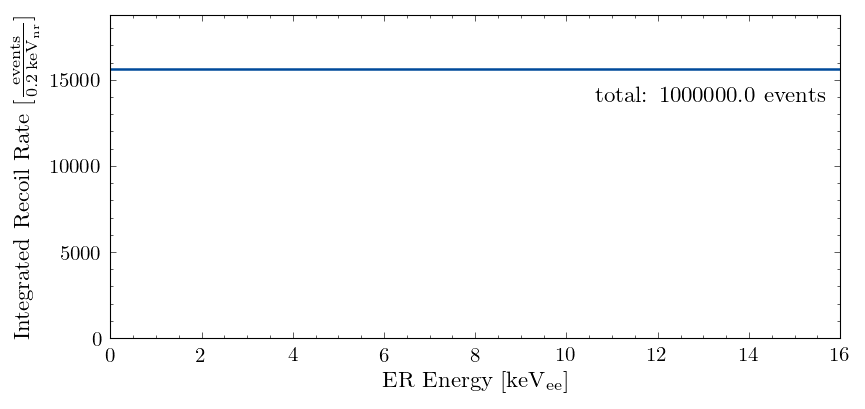

In [14]:
    
if flag_plot_spectra == True:

    data = np.load("./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data["energy_deposition"], counts=data["number_of_events"])

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #plt.yscale("log")
    y_lim = [0, 1.2*max(data["number_of_events"])]
    ax1.set_xlim(recoilenergyrange_er)
    ax1.set_ylim(y_lim)
    plt.xlabel(r"ER Energy $[\mathrm{keV}_{\mathrm{ee}}]$")
    plt.ylabel(r"Integrated Recoil Rate $[\frac{\mathrm{events}}{" +f"{er_binwidth:.1f}"+"\,\mathrm{keV}_{\mathrm{nr}}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    # plotting
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: " +f"{sum(data['number_of_events'])}" +" events", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__er_background_constant_absolute.png")


differential WIMP recoil spectrum in LXe_nat

SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material: your relative abundances add up to 100.0 %


./../../SF_spectrum.py:207: RuntimeWarning: invalid value encountered in double_scalars
  return a/b *c
./../../SF_spectrum.py:228: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scaling_factor *number_of_target_nuclei *(wimp_dark_matter_mass_density/mass_wimp_gev) *quad(integrand_function, velocity_min, velocity_escape +velocity_circular, args=(energy_nuclear_recoil))[0]


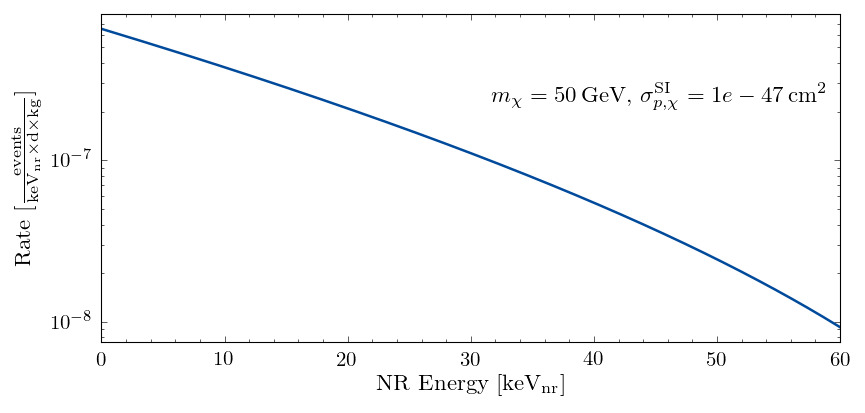

In [15]:
    
if flag_plot_spectra == True:

    # generating data
    e_nr_list, diff_rate_list = SF_spectrum.wimp_recoil_spectrum_for_composite_detector_material(
        mass_wimp_gev = wimpmass,
        cross_section_wimp_proton_cm2 = wimpcrosssection,
        energy_threshold_kev = 0,
        energy_nuclear_recoil_min = recoilenergyrange_nr[0],
        energy_nuclear_recoil_max = recoilenergyrange_nr[1],
        number_of_bins_or_samples=500,
        flag_output = "rate"
    )

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    plt.yscale("log")
    x_lim = recoilenergyrange_nr
    #y_lim = [1e-10, 1e-6]
    #y_lim = [min(diff_rate_list), 1.2*max(diff_rate_list)]
    ax1.set_xlim(x_lim)
    #ax1.set_ylim(y_lim)
    plt.xlabel(r"NR Energy $[\mathrm{keV}_{\mathrm{nr}}]$")
    plt.ylabel(r"Rate $[\frac{\mathrm{events}}{\mathrm{keV}_{\mathrm{nr}}\times\mathrm{d}\times\mathrm{kg}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")


    # plotting
    plt.plot(e_nr_list, diff_rate_list, color=uni_blue)
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{wimpcrosssection}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__differential_wimp_recoil_spectrum_in_xenon_nat.png")


absolute WIMP NR rate spectrum

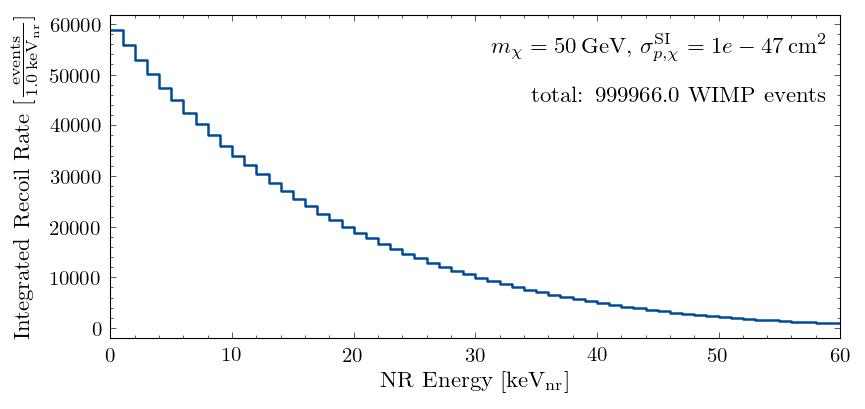

In [16]:

if flag_plot_wimp_recoil_spectra == True:

    # loading data
    data = np.load("./data/spectra/" +filename_nr_spectrum +str(paramrange_edrift[0]) +".npy")
    e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data["energy_deposition"], counts=data["number_of_events"])
    binwidth = e_nr_bin_centers_list_stepized[2] -e_nr_bin_centers_list_stepized[0]
    noe_wr = np.sum(0.5*abs_nr_rate_list_stepized)

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #plt.yscale("log")
   #y_lim = [0, 100]
    ax1.set_xlim(recoilenergyrange_nr)
    #ax1.set_ylim(y_lim)
    plt.xlabel(r"NR Energy $[\mathrm{keV}_{\mathrm{nr}}]$")
    plt.ylabel(r"Integrated Recoil Rate $[\frac{\mathrm{events}}{" +f"{binwidth:.1f}"+"\,\mathrm{keV}_{\mathrm{nr}}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    # plotting
    plt.plot(e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized, color=uni_blue)
    plt.text(x=0.98, y=0.9, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{wimpcrosssection}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: " +f"{noe_wr:.1f}" +r" WIMP events", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__wimp_absolute.png")


combined er and nr recoil spectra

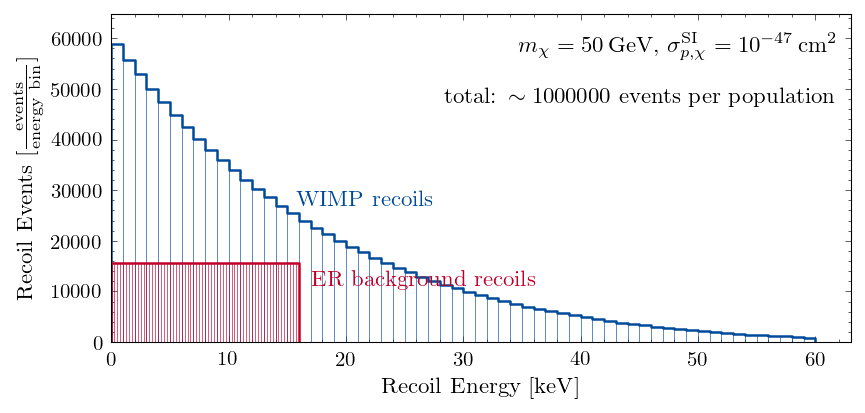

In [17]:
             
if flag_plot_wimp_recoil_spectra == True:

    # nr data
    data_nr = np.load("./data/spectra/" +filename_nr_spectrum +str(paramrange_edrift[0]) +".npy")
    e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_nr["energy_deposition"], counts=data_nr["number_of_events"])
    e_nr_bin_centers_list_stepized = list(e_nr_bin_centers_list_stepized)
    abs_nr_rate_list_stepized = list(abs_nr_rate_list_stepized)
    noe_nr = 0.5*np.sum(abs_nr_rate_list_stepized)

    # er data
    data_er = np.load("./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[0]) +".npy")
    e_er_bin_centers_list_stepized, abs_er_rate_list_stepized = SF_process.stepize_histogram_data(bincenters=data_er["energy_deposition"], counts=data_er["number_of_events"])
    e_er_bin_centers_list_stepized = list(e_er_bin_centers_list_stepized)
    abs_er_rate_list_stepized = list(abs_er_rate_list_stepized)
    noe_er = 0.5*np.sum(abs_er_rate_list_stepized)
    binwidth_er = e_er_bin_centers_list_stepized[2] -e_er_bin_centers_list_stepized[0]

    # setting up the canvas
    #fig, ax1 =plt.subplots(figsize=(5.670, 3.189), dpi=150)
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    x_lim_list = [0,1.05*max(max(e_nr_bin_centers_list_stepized),max(e_er_bin_centers_list_stepized))]
    y_lim_list = [0,1.1*max(max(abs_nr_rate_list_stepized),max(abs_er_rate_list_stepized))]
    ax1.set_xlim(x_lim_list)
    ax1.set_ylim(y_lim_list)
    plt.xlabel(r"Recoil Energy $[\mathrm{keV}]$")
    plt.ylabel(r"Recoil Events $[\frac{\mathrm{events}}{\mathrm{energy\,\,bin}}]$")
    #plt.title(r"WIMP recoil spectrum ($m_{\chi}="+ f"{m_chi}" +"\,\mathrm{GeV},\,\sigma_{\chi,p}^{\mathrm{SI}}=" +f"{sigma}" +"\,\mathrm{cm^2}$)")

    ### plotting
    # vertical histogram lines
    for i in range(len(e_nr_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_nr_bin_centers_list_stepized[i], e_nr_bin_centers_list_stepized[i]], [0, abs_nr_rate_list_stepized[i]], linewidth=0.3, color=color_nrs)
    for i in range(len(e_er_bin_centers_list_stepized)):
        if (i==0) or (i%2==0):
            plt.plot([e_er_bin_centers_list_stepized[i], e_er_bin_centers_list_stepized[i]], [0, abs_er_rate_list_stepized[i]], linewidth=0.3, color=color_ers)
    # histogram data
    #e_nr_bin_centers_list_stepized.append(e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1])
    #abs_nr_rate_list_stepized.append(0)
    #e_er_bin_centers_list_stepized.append(e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1])
    #abs_er_rate_list_stepized.append(0)
    e_er_bin_centers_list_stepized = [e_er_bin_centers_list_stepized[0]] +e_er_bin_centers_list_stepized +[e_er_bin_centers_list_stepized[len(e_er_bin_centers_list_stepized)-1]]
    abs_er_rate_list_stepized = [0] +abs_er_rate_list_stepized +[0]
    e_nr_bin_centers_list_stepized = [e_nr_bin_centers_list_stepized[0]] +e_nr_bin_centers_list_stepized +[e_nr_bin_centers_list_stepized[len(e_nr_bin_centers_list_stepized)-1]]
    abs_nr_rate_list_stepized = [0] +abs_nr_rate_list_stepized +[0]
    plt.plot(e_nr_bin_centers_list_stepized, abs_nr_rate_list_stepized, color=uni_blue)
    plt.plot(e_er_bin_centers_list_stepized, abs_er_rate_list_stepized, color=uni_red)
    # text
    plt.text(x=0.98, y=0.9, transform=ax1.transAxes, s=r"$m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{SF_process.exponential_float_to_latex(expfloat=wimpcrosssection)}" +r"\,\mathrm{cm^2}$", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.98, y=0.75, transform=ax1.transAxes, s=r"total: $\sim" +f"{number_of_events_per_population}" +"$ events per population", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    #plt.text(x=0.98, y=0.60, transform=ax1.transAxes, s=r"(flat ER background: $" +f"\sim {abs_er_rate_list_stepized[0]:.0f}" +r"\,\frac{\mathrm{events}}{" +f"{binwidth_er:.2f}" +r"\,\mathrm{keV}}$)", color="black", fontsize=11, verticalalignment='center', horizontalalignment='right')
    plt.text(x=0.25, y=0.40, transform=ax1.transAxes, s=r"WIMP recoils", color=uni_blue, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    plt.text(x=0.27, y=0.16, transform=ax1.transAxes, s=r"ER background recoils", color=uni_red, fontsize=11, verticalalignment='bottom', horizontalalignment='left')
    #plt.legend()
    plt.show()
    fig.savefig(f"./output/input_recoil_spectrum__er_and_nr_rates_absolute.png")
    fig.savefig(f"./../../../20200519__wg4_meeting_talk__sfs/images/input_recoil_spectrum__er_and_nr_rates_absolute.png")


# 3. Generating Signature Data

In [ ]:

if flag_generate_raw_data == True:


    ### looping over all possible parameter combinations (edrift and detector parameters)
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():


            # implementing the just generated detector header file into NEST
            SF_nestcom.SF_nestcom_implementdetector(
                filestring_detector = "./data/detectors/" +detector_filename +key +".hh"
            )

            # running NEST with the just adjusted detector and both the ER background and WIMP spectra
            SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = "./data/spectra/" +filename_er_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = "./data/signatures/",
                detectorname = detector_filename +key,
                output_pre_string="simdata"
            )
            SF_nestcom.SF_nestcom_runnest(
                filestring_spectrum = "./data/spectra/" +filename_nr_spectrum +str(paramrange_edrift[i]) +".npy",
                pathstring_output = "./data/signatures/",
                detectorname = detector_filename +key,
                output_pre_string="simdata"
            )


#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1500_g1_0_11.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying data of file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: editing file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: performing a clean re-install
SF_nestcom_implementdetector: performed 'make clean'
SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_n

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_11344__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: generating simdata__wimps_edrift_250__eLife_us_1500_g1_0_11.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_250__eLife_us_1500_g1_0_11
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_250__eLife_us_1500_g1_0_11.npy
SF_nestcom_runnest: 

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15644__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_21277__INTERA

SF_nestcom_runnest: successfully ran EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2164__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_30291__INTERACTION

SF_nestcom_runnest: successfully ran EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3578__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_r

SF_nestcom_runnest: saved EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_44892__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_5664__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_250__eLife_us_1750_g1_0_13.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_250__eLife_us_1750_g1_0_13
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_250__eLife_us_1750_g1_0_13.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_5882

SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__

SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_9931__INTERAC

SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: generating simdata__wimps_edrift_250__eLife_us_2000_g1_0_13.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_250__eLife_us_2000_g1_0_13
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_250__eLife_us_2000_g1_0_13.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_2250_g1_0_13.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying d

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_13781__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1008__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_18844__INTERA

SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1809__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_26974__INTERA

SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3042__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_250_0
SF_nes

SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_40195__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4880__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_250__eLife_us_2250_g1_0_15
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_250__eLife_us_2250_g1_0_15.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_55766__INTERACT

SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_7548__INTERACTION_NR__EN

SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_250

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_9931__INTERAC

SF_nestcom_runnest: successfully ran EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_250_0
SF_nestcom_runnest: generating simdata__wimps_edrift_250__eLife_us_1500_g1_0_17.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_250__eLife_us_1500_g1_0_17
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_250__eLife_us_1500_g1_0_17.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1750_g

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15644__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_22593__INTERA

SF_nestcom_runnest: successfully ran EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_250_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_250_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR

SF_nestcom_runnest: successfully ran EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_250_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: saved EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__EN

SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_500_

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_500__eLife_us_1750_g1_0_11.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_500__eLife_us_1750_g1_0_11
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_500__eLi

SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTIO

SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_500__eLife_us_1750_g1_0_11
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_500__eLife_us_1750_g1_0_11.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_2000_g1_0_11.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying data of file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: editing file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: performing a clean r

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_13781__INTERACTION_NR__ENERGY_25_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_12924__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1117__INTERACTION_NR__ENERGY_57_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_906__INTERACTION_NR__ENE

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_17720__INTERA

SF_nestcom_runnest: saved EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_25438__INTERA

SF_nestcom_runnest: successfully ran EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2800__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: saved EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_38013__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4523__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__EN

SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_9931__INTERAC

SF_nestcom_runnest: successfully ran EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1008__INTERACTION_NR__ENERGY_58_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_500_0
SF_nestcom_runnest: generating simdata__wimps_edrift_500__eLife_us_2250_g1_0_13.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_500__eLife_us_2250_g1_0_13
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_500__eLife_us_2250_g1_0_13.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1500_g

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_20028__INTERACTION_NR__ENERGY_19_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_18844__INTERACTION_NR__ENERGY_20_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15644__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1980__INTERACTION_NR__ENERGY_51_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1809__INTERACTION_NR__ENERGY_52_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_28591__INTERACTION_NR__ENERGY_13_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_26974__INTERACTION_NR__ENERGY_14_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_22593__INTERA

SF_nestcom_runnest: successfully ran EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3301__INTERACTION_NR__ENERGY_45_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3042__INTERACTION_NR__ENERGY_46_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_40195__INTERACTION_NR__ENERGY_7_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_38013__INTERACTION_NR__ENERGY_8_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR

SF_nestcom_runnest: successfully ran EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_5260__INTERACTION_NR__ENERGY_39_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4880__INTERACTION_NR__ENERGY_40_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: saved EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_55766__INTERACTION_NR__ENERGY_1_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_8093__INTERACTION_NR__ENERGY_33_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7548__INTERACTION_NR__ENERGY_34_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__EN

SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_500_

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_500_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_500__eLife_us_1500_g1_0_17.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_500__eLife_us_1500_g1_0_17
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_500__eLi

SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTIO

SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_500_0
SF_nestcom_runnest: generating simdata__wimps_edrift_500__eLife_us_1500_g1_0_17.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_500__eLife_us_1500_g1_0_17
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_500__eLife_us_1500_g1_0_17.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1750_g1_0_17.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying d

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_13781__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1117__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_20028__INTERA

SF_nestcom_runnest: successfully ran EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_1980__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_500_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_500_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_28591__INTERACT

SF_nestcom_runnest: successfully ran EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: successfully ran EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: saved EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_500_0
SF_nestcom_runnest: running EVENTS_3301__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestco

SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_42486__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_5260__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_750__eLife_us_1750_g1_0_11.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_750__eLife_us_1750_g1_0_11
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_750__eLife_us_1750_g1_0_11.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_5882

SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__

SF_nestcom_implementdetector: performed 'make clean'
SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: running EVE

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9931__INTERAC

SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_750_0
SF_nestcom_runnest: generating simdata__wimps_edrift_750__eLife_us_2000_g1_0_11.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_750__eLife_us_2000_g1_0_11
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_750__eLife_us_2000_g1_0_11.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_2250_g1_0_11.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying d

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_13781__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1117__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_5_625__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_12_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_375__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_25438__INTERACTION_NR__ENERGY_15_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_23979__INTERACTION_NR__ENERGY_16_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_22593__INTERACTION_NR__ENERGY_17_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_21277__INTERACTION_NR__ENERGY_18_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_20028__INTERA

SF_nestcom_runnest: successfully ran EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_2800__INTERACTION_NR__ENERGY_47_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_2573__INTERACTION_NR__ENERGY_48_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_2362__INTERACTION_NR__ENERGY_49_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_2164__INTERACTION_NR__ENERGY_50_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1980__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_3_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_4_125__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_11_875__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_35936__INTERACTION_NR__ENERGY_9_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_33960__INTERACTION_NR__ENERGY_10_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_32080__INTERACTION_NR__ENERGY_11_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_30291__INTERACTION_NR__ENERGY_12_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_28591__INTERACT

SF_nestcom_runnest: successfully ran EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_4523__INTERACTION_NR__ENERGY_41_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_4187__INTERACTION_NR__ENERGY_42_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_3873__INTERACTION_NR__ENERGY_43_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_3578__INTERACTION_NR__ENERGY_44_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_3301__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_2_625__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_9_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_10_375__EDRIFT_750_0
SF_nestco

SF_nestcom_runnest: saved EVENTS_52849__INTERACTION_NR__ENERGY_2_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_50068__INTERACTION_NR__ENERGY_3_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_47418__INTERACTION_NR__ENERGY_4_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_44892__INTERACTION_NR__ENERGY_5_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_42486__INTERACTION_NR__ENERGY_6_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_42486__INTERACTION_NR__E

SF_nestcom_runnest: successfully ran EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_7034__INTERACTION_NR__ENERGY_35_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_6550__INTERACTION_NR__ENERGY_36_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_6093__INTERACTION_NR__ENERGY_37_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_5664__INTERACTION_NR__ENERGY_38_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_5260__INTERACTION_NR__EN

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_1_125__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_875__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: generating simdata__erbkg_edrift_750__eLife_us_2250_g1_0_13.npy
SF_nestcom_runnest: generated concatenated array simdata__erbkg_edrift_750__eLife_us_2250_g1_0_13
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__erbkg_edrift_750__eLife_us_2250_g1_0_13.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_58825__INTERACTION_NR__ENERGY_0_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_5882

SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_9931__INTERACTION_NR__ENERGY_30_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_9283__INTERACTION_NR__ENERGY_31_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_8671__INTERACTION_NR__ENERGY_32_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_8093__INTERACTION_NR__

SF_nestcom_implementdetector: performed 'make'
SF_nestcom_implementdetector: performed 'make install'
SF_nestcom_implementdetector: finished ---> success
#######################################

#######################################
SF_nestcom_runnest: initializing.
SF_nestcom_runnest: running NEST via: $ testNEST <n_events> <ER_or_NR> <e_dep_min> <e_dep_max> <e_drift> <pos>
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_0_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_0_625__EDRIFT_750

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_7_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_8_125__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_15_875__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_12924__INTERACTION_NR__ENERGY_26_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_12112__INTERACTION_NR__ENERGY_27_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_11344__INTERACTION_NR__ENERGY_28_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_10618__INTERACTION_NR__ENERGY_29_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_9931__INTERAC

SF_nestcom_runnest: successfully ran EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_906__INTERACTION_NR__ENERGY_59_5__EDRIFT_750_0
SF_nestcom_runnest: generating simdata__wimps_edrift_750__eLife_us_1500_g1_0_15.npy
SF_nestcom_runnest: generated concatenated array simdata__wimps_edrift_750__eLife_us_1500_g1_0_15
SF_nestcom_runnest: saved concatenated array ./data/signatures/simdata__wimps_edrift_750__eLife_us_1500_g1_0_15.npy
SF_nestcom_runnest: cleaned up ./temp/
SF_nestcom_runnest: finished ---> success
#######################################

#######################################
SF_nestcom_implementdetector: Initializing.
SF_nestcom_implementdetector: copied './data/detectors/eLife_us_1750_g1_0_15.hh' into '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/include/Detectors/'
SF_nestcom_implementdetector: reading in file '/home/daniel/Desktop/arbeitsstuff/NEST4/install/../nest/src/testNEST.cpp'
SF_nestcom_implementdetector: modifying d

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_625__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_6_875__EDRIFT_750_0
SF_nestcom_runn

SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_13_875__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_125__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_375__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15625__INTERACTION_beta__ENERGY_14_625__EDRIFT_750_0
SF_n

SF_nestcom_runnest: successfully ran EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_17720__INTERACTION_NR__ENERGY_21_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_16654__INTERACTION_NR__ENERGY_22_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_15644__INTERACTION_NR__ENERGY_23_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_14688__INTERACTION_NR__ENERGY_24_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_13781__INTERA

SF_nestcom_runnest: successfully ran EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1649__INTERACTION_NR__ENERGY_53_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1501__INTERACTION_NR__ENERGY_54_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1363__INTERACTION_NR__ENERGY_55_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: successfully ran EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: saved EVENTS_1235__INTERACTION_NR__ENERGY_56_5__EDRIFT_750_0
SF_nestcom_runnest: running EVENTS_1117__INTERACTION_NR__EN

# 4. Analysis

## 4.0 Investigations in Advance

The cell below is used to investigate the various populations popping up in the cS1/cS2 observable space and gain an understanding regarding their origin.<br>
Hereby a few unphysical populations were identified that correspond to negative (i.e. unphysical) cS1 and cS2 values.

In [ ]:

flag_investigate_populations = True

if flag_investigate_populations == True:

    # defining the parameters (testing)
    param_dict = {
        "edrift" : 750,
        "g1" : 0.15,
        "eLife_us" : 2000
    }

    # loading data
    er_data = np.load(path_input +"simdata__erbkg_edrift_750__g1_0_15_eLife_us_2000.npy")
    nr_data = np.load(path_input +"simdata__wimps_edrift_750__g1_0_15_eLife_us_2000.npy")
    er_s1_over_g1 = np.divide(er_data["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1 = np.log10(np.divide(er_data["s2_phe"], er_data["s1_phe"]))
    nr_s1_over_g1 = np.divide(nr_data["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1 = np.log10(np.divide(nr_data["s2_phe"], nr_data["s1_phe"]))

    # strange data 1: cS1 == cS2 == -10**(-6)
    threshold_s1 = 0.1
    threshold_s2 = 0.1
    er_data_strange_1 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_1 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_1 = np.divide(er_data_strange_1["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_1 = np.log10(np.divide(er_data_strange_1["s2_phe"], er_data_strange_1["s1_phe"]))
    nr_s1_over_g1_strange_1 = np.divide(nr_data_strange_1["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_1 = np.log10(np.divide(nr_data_strange_1["s2_phe"], nr_data_strange_1["s1_phe"]))
    
    # strange data 2: cS1 == -10**(-6) != cS2
    er_data_strange_2 = er_data[(er_data["s1_phe"] == -10**(-6)) & (er_data["s2_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6))]
    nr_data_strange_2 = nr_data[(nr_data["s1_phe"] == -10**(-6)) & (nr_data["s2_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6))]
    er_s1_over_g1_strange_2 = np.divide(er_data_strange_2["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_2 = np.log10(np.divide(er_data_strange_2["s2_phe"], er_data_strange_2["s1_phe"]))
    nr_s1_over_g1_strange_2 = np.divide(nr_data_strange_2["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_2 = np.log10(np.divide(nr_data_strange_2["s2_phe"], nr_data_strange_2["s1_phe"]))

    # strange data 3: cS1 =! -10**(-6) == cS2
    er_data_strange_3 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] == -10**(-6))]
    nr_data_strange_3 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] == -10**(-6))]
    er_s1_over_g1_strange_3 = np.divide(er_data_strange_3["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_3 = np.log10(np.divide(er_data_strange_3["s2_phe"], er_data_strange_3["s1_phe"]))
    nr_s1_over_g1_strange_3 = np.divide(nr_data_strange_3["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_3 = np.log10(np.divide(nr_data_strange_3["s2_phe"], nr_data_strange_3["s1_phe"]))

    # strange data 4: cS1 =! -10**(-6) != cS2
    er_data_strange_4 = er_data[(er_data["s1_phe"] != -10**(-6)) & (er_data["s1_phe"] <= 0) & (er_data["s2_phe"] != -10**(-6)) & (er_data["s2_phe"] <= 0)]
    nr_data_strange_4 = nr_data[(nr_data["s1_phe"] != -10**(-6)) & (nr_data["s1_phe"] <= 0) & (nr_data["s2_phe"] != -10**(-6)) & (nr_data["s2_phe"] <= 0)]
    er_s1_over_g1_strange_4 = np.divide(er_data_strange_4["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_strange_4 = np.log10(np.divide(er_data_strange_4["s2_phe"], er_data_strange_4["s1_phe"]))
    nr_s1_over_g1_strange_4 = np.divide(nr_data_strange_4["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_strange_4 = np.log10(np.divide(nr_data_strange_4["s2_phe"], nr_data_strange_4["s1_phe"]))

    # modified data
    er_data_mod = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
    nr_data_mod = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]
    er_s1_over_g1_mod = np.divide(er_data_mod["s1_phe"], param_dict["g1"])
    er_log10_s2_over_s1_mod = np.log10(np.divide(er_data_mod["s2_phe"], er_data_mod["s1_phe"]))
    nr_s1_over_g1_mod = np.divide(nr_data_mod["s1_phe"], param_dict["g1"])
    nr_log10_s2_over_s1_mod = np.log10(np.divide(nr_data_mod["s2_phe"], nr_data_mod["s1_phe"]))
   
    # investigating strange populations
    print("strange populations:")
    print(er_data.dtype.names)
    threshold = 5
    investigation_data_er = er_data[(er_data["s1_phe"]<=threshold) & (er_data["s1_phe"]>=threshold) & (er_data["s2_phe"]<=threshold) & (er_data["s2_phe"]>=threshold)]
    for i in range(len(investigation_data_er)):
        print(investigation_data_er[i])

    ### plotting
    # formatting
    fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
    #ax1.set_xlim([0,500])
    #ax1.set_ylim([2,3.75])
    plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{PE}]$")
    plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")
    # plotting data
    plt.text(x=0.45, y=0.70, s=r"ER Background", transform=ax1.transAxes, color=color_ers, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1, y=er_log10_s2_over_s1, s=4, facecolor=color_ers, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    plt.text(x=0.45, y=0.55, s=r"WIMP NRs", transform=ax1.transAxes, color=color_nrs, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=nr_s1_over_g1, y=nr_log10_s2_over_s1, s=4, facecolor=color_nrs, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
    color_strange_1 = "green"
    plt.text(x=0.07, y=0.44, s=r"$cS1 = cS2 = -10^{-6}$", transform=ax1.transAxes, color=color_strange_1, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_1, y=er_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_1, y=nr_log10_s2_over_s1_strange_1, s=4, facecolor=color_strange_1, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_2 = "cyan"
    plt.text(x=0.07, y=0.91, s=r"$cS1 = -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_2, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_2, y=er_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_2, y=nr_log10_s2_over_s1_strange_2, s=4, facecolor=color_strange_2, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_3 = "orange"
    plt.text(x=0.07, y=0.11, s=r"$cS1 \neq -10^{-6} = cS2$", transform=ax1.transAxes, color=color_strange_3, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_3, y=er_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_3, y=nr_log10_s2_over_s1_strange_3, s=4, facecolor=color_strange_3, marker=".", alpha=1, linewidths=0, edgecolors=None)
    color_strange_4 = "purple"
    plt.text(x=0.07, y=0.57, s=r"$cS1 \neq -10^{-6} \neq cS2$", transform=ax1.transAxes, color=color_strange_4, fontsize=11, verticalalignment='top', horizontalalignment='left')
    plt.scatter(x=er_s1_over_g1_strange_4, y=er_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    plt.scatter(x=nr_s1_over_g1_strange_4, y=nr_log10_s2_over_s1_strange_4, s=4, facecolor=color_strange_4, marker=".", alpha=1, linewidths=0, edgecolors=None)
    #plt.legend()
    # saving
    plt.show()
    savename = "investigating_strange_populations_"
    savestring = ""
    for key, val in param_dict.items():
        savestring = savestring +"_" +key +"_" +str(val).replace(".","_")
    fig.savefig(path_output +savename +savestring +".png")
    fig.savefig(path_presentation +savename +savestring +".png")


Conclusion:<br>
Apparently some events (preferrably lower energetic ones) yield negative and strange S1 and/or S2 signatures within NEST (probably due to threshold effects). If only either of the S1 and S2 values is negative, then the argument of 'np.log10' is negative and 'np.log10' evaluates to 'NaN'; those events are not plotted at all. If both S1 and S2 are negative, the the argument of 'np.log10' is positive again. Nevertheless these events are considered neglected. Furthermore '-10**(-6)' appears to be some relevant default return value. In the plot above the various discarded populations have been identified. In order to discard those events it is sufficient to just process events with S1 and S2 values greater than 0.

## 4.1 Looping over Populations

This cell is used to loop over the whole parameter space and analyze the various couples of ER/NR populations individually. The respective analysis data is stored within a ndarray.

In [ ]:

# general analysis parameters
observable_range = [0,500]
observable_range_number_of_bins = 50
observable_range_bin_edges = np.linspace(num=observable_range_number_of_bins, start=observable_range[0], stop=observable_range[1], endpoint=True)
leakage_fraction_percentile = 50 # e.g. 50: for an ER event to be considered 'leaking' it has to be 'lower' than 50 percent of the NR events within that bin.
threshold_events_per_bin = 60
name_popdata = "popdata"
color_discrimination_line = "black"
color_parameter_annotations = "grey"
ctr = 0 # to restrict runtime
ctr_threshold = 10**6
name_wimps_plot_description = r"WIMP NRs ($m_{\chi}=" +f"{wimpmass}" +r"\,\mathrm{GeV}$, " +r"$\sigma^{\mathrm{SI}}_{p,\chi}=" +f"{SF_process.exponential_float_to_latex(expfloat=wimpcrosssection)}" +r"\,\mathrm{cm^2}$)"
name_erbkg_plot_description = r"ER background (flat)"
name_discrimination_line_annotation_1 = r"discrimination\_line ($p=" +f"{(leakage_fraction_percentile):.1f}" +r"\,\%,\,\,L="
name_discrimination_line_annotation_2 = "\,\%$)"
name_data_generation_for_presentation = "data_generation_for_presentation"

# setting up the 'summarized_data' ndarray
summarized_data_dtype_list = [("edrift", np.float64)]
for key, value in darwin_detector_parameter_space.items():
    summarized_data_dtype_list.append((key, np.float64))
summarized_data_dtype = np.dtype(summarized_data_dtype_list +[
#    ("leakage", np.float64),
])
summarized_data_tuplelist = []


# looping over every ER/NR pair
#flag_analysis_loop = True
if flag_analysis_loop == True:

    ### running the analysis on the corresponding populations
    for i in range(len(paramrange_edrift)):
        for key, val in parameter_sweep_dictionaries.items():
            if ctr <= ctr_threshold:

                ### generating modified data (i.e. cS1/g1 and log10(cS2/cS1))
                # loading the data
                er_data = np.load(path_signatures +name_simdata +"__" +filename_er_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                nr_data = np.load(path_signatures +name_simdata +"__" +filename_nr_spectrum +str(paramrange_edrift[i]) +"__" +key +".npy")
                # data selection (cutting the events with negative S1 and S2 values)
                er_data_selected = er_data[(er_data["s1_phe"] >= 0) & (er_data["s2_phe"] >= 0)]
                nr_data_selected = nr_data[(nr_data["s1_phe"] >= 0) & (nr_data["s2_phe"] >= 0)]
                # generating the modified ndarrays containing the relevant information
                new_dtype = np.dtype([("s1_g1", np.float64), ("lg_s2_s1", np.float64)]) #er_data_selected.dtype.descr
                er_data_mod = np.array([(er_data_selected["s1_phe"][i]/val["g1"], np.log10(er_data_selected["s2_phe"][i]/er_data_selected["s1_phe"][i])) for i in range(len(er_data_selected))], dtype=new_dtype)
                nr_data_mod = np.array([(nr_data_selected["s1_phe"][i]/val["g1"], np.log10(nr_data_selected["s2_phe"][i]/nr_data_selected["s1_phe"][i])) for i in range(len(nr_data_selected))], dtype=new_dtype)

                ### analysis stuff
                # defining the 'popdata' ndarray dtype
                popdata_dtype = [
                    ("bin_center", np.float64),
                    ("threshold_value", np.float64),
                    ("n_nr_events_in_bin", np.uint64),
                    ("n_er_events_in_bin", np.uint64),
                    ("n_er_events_below_threshold", np.uint64),
                    ("leakage_fraction_in_bin", np.float64),
                    ("leakage_fraction_in_bin_error", np.float64)
                ]
                popdata_tuple_list = []
                # looping over the energy bins
                # to generate 'popdata' data and add it to the 'popdata_tuple_list'
                for j in range(len(observable_range_bin_edges)-1):
                    binwidth = observable_range_bin_edges[j+1] -observable_range_bin_edges[j]
                    er_current_bin_data = er_data_mod[(er_data_mod["s1_g1"] >= observable_range_bin_edges[j]) & (er_data_mod["s1_g1"] <= observable_range_bin_edges[j+1])]
                    nr_current_bin_data = nr_data_mod[(nr_data_mod["s1_g1"] >= observable_range_bin_edges[j]) & (nr_data_mod["s1_g1"] <= observable_range_bin_edges[j+1])]
                    n_nr = len(nr_current_bin_data)
                    n_er = len(er_current_bin_data)
                    if (n_er > threshold_events_per_bin) and (n_nr > threshold_events_per_bin):
                        percentile_index = int(len(nr_current_bin_data)*(leakage_fraction_percentile/100))
                        percentile_threshold_value = sorted(list(nr_current_bin_data["lg_s2_s1"]))[percentile_index]
                        n_er_below_threshold = len(er_current_bin_data[(er_current_bin_data["lg_s2_s1"] <= percentile_threshold_value)])
                        leakage_fraction_within_current_bin = n_er_below_threshold/n_er
                        leakage_fraction_within_current_bin_error = np.sqrt(n_er_below_threshold)/n_er
                        # adding data to the 'popdata_tuple_list'
                        popdata_tuple_list.append((
                            observable_range_bin_edges[j]+0.5*binwidth, # "bin_center"
                            percentile_threshold_value, # "threshold_value"
                            n_nr, # "n_nr_events_in_bin"
                            n_er, # "n_er_events_in_bin"
                            n_er_below_threshold, # "n_er_below_threshold"
                            leakage_fraction_within_current_bin, # "leakage_fraction_in_bin"
                            leakage_fraction_within_current_bin_error # "leakage_fraction_in_bin_error"
                        ))
                # adding data to the 'summarized_data' ndarray
                summarized_data_appendtuple = (paramrange_edrift[i], )
                for k, v in parameter_sweep_dictionaries[key].items():
                    if k in key:
                        summarized_data_appendtuple = summarized_data_appendtuple +(v, )
                summarized_data_tuplelist.append(summarized_data_appendtuple)
                # saving the 'popdata' ndarray
                popdata_ndarray = np.array(popdata_tuple_list, popdata_dtype)
                np.save(path_popdata +name_popdata +"__edrift_" +f"{paramrange_edrift[i]}_" +key +".npy", popdata_ndarray)
                
                ### plotting
                # formatting
                fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                ax1.set_xlim(observable_range)
                plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{PE}]$")
                plt.ylabel(r"$\mathrm{log}_{10}\left(\frac{cS2}{cS1}\right)$")
                # plotting data
                plt.scatter(x=er_data_mod["s1_g1"], y=er_data_mod["lg_s2_s1"], s=4, facecolor=color_ers, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
                plt.scatter(x=nr_data_mod["s1_g1"], y=nr_data_mod["lg_s2_s1"], s=4, facecolor=color_nrs, marker=".", alpha=0.45, linewidths=0, edgecolors=None)
                leakage_fraction_x, leakage_fraction_y = SF_process.stepize_histogram_data(bincenters=popdata_ndarray["bin_center"], counts=popdata_ndarray["threshold_value"])
                plt.plot(leakage_fraction_x, leakage_fraction_y, color=color_discrimination_line, linewidth=0.8)
                # annotations
                plt.text(x=0.08, y=0.79, transform=ax1.transAxes, s=name_erbkg_plot_description, color=color_ers, fontsize=11, verticalalignment='center', horizontalalignment='left')
                plt.text(x=0.08, y=0.20, transform=ax1.transAxes, s=name_wimps_plot_description, color=color_nrs, fontsize=11, verticalalignment='center', horizontalalignment='left')
                parameter_vertical_linespacing = 0.1
                parameter_pos_x = 0.98
                parameter_pos_y = 0.89
                parameter_pos_ctr = 1
                plt.text(x=parameter_pos_x, y=parameter_pos_y, transform=ax1.transAxes, s=r"\texttt{edrift}: " +f"{paramrange_edrift[i]}", color=color_parameter_annotations, fontsize=11, verticalalignment='center', horizontalalignment='right')
                for k, v in parameter_sweep_dictionaries[key].items():
                    if k in key:
                        parameterstring = k.replace('_','\_')
                        plt.text(x=parameter_pos_x, y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing, transform=ax1.transAxes, s=r"\texttt{" +f"{parameterstring}" +r"}: " +f"{v}", color=color_parameter_annotations, fontsize=11, verticalalignment='center', horizontalalignment='right')
                        parameter_pos_ctr += 1
                plt.text(x=0.30, y=0.47, transform=ax1.transAxes, s=name_discrimination_line_annotation_1 +f"{12.785:.1f}" +name_discrimination_line_annotation_2, color=color_discrimination_line, fontsize=11, verticalalignment='center', horizontalalignment='left')
                #plt.legend()
                # saving
                savename = "poplot"
                savestring = "__edrift_" +f"{paramrange_edrift[i]}"
                for k, v in val.items():
                    if k in key:
                        savestring = savestring +"_" +k +"_" +str(v).replace(".","_")
                fig.savefig(path_output_poplots +savename +savestring +".png")
                ctr += 1

                ### plotting for presentations
                if (paramrange_edrift[i] == 250) and (key == "g1_0_11_eLife_us_1500"):
                    fig.savefig(path_output +name_data_generation_for_presentation +".png")
                    fig.savefig(path_presentation +name_data_generation_for_presentation +".png")

    ### saving the 'summarized_data' ndarray
    summarized_data_ndarray = np.array(summarized_data_tuplelist, summarized_data_dtype)
    np.save(path_input +name_summarized_data +".npy", summarized_data_ndarray)


## 4.2 Comparing Populations

This cell is meant to generate a dictionary (`cumulative_investigation_dictionary`) of the following form:

<code>
    cumulative_investigation_dictionary = {

        `investigation_parameter_1` : {
        
            `constant_parameter_string_1_1` : [
                `filename_1`,
                `filename_2`,
                `filename_3`,
                `filename_4`,
                `filename_5`,
                `filename_6`,
                `filename_7`
            ], 
            
            `constant_parameter_string_1_2` : [
                ...
            ]
        },

        `investigation_parameter_2` : {
            ...
        },

        ...
    
    }
<code>


In the further work of this section this dictionary will be used to loop over and to generate plots for each collection of filenames.

In [ ]:

### defining a dictionary containing all parameters to be looped over (i.e. inc. 'edrift')
parameter_dictionary = darwin_detector_parameter_space.copy()
parameter_dictionary.update({"edrift" : paramrange_edrift})

### defining the output 'cumulative_investigation_dictionary'
cumulative_investigation_dictionary = parameter_dictionary.copy()
for key, val in cumulative_investigation_dictionary.items():
    cumulative_investigation_dictionary[key] = {}

### looping over all 'investigation_parameter's and and generating the 'cartesian_list'
### containing every possible combination of static parameter values for this specific 'investigation_parameter'
for investigation_parameter in ["edrift"] +[*darwin_detector_parameter_space]:
    # generating a dictionary containing all keys but the current 'investigation_parameter'
    parameter_dictionary_without_investigation_parameter = parameter_dictionary.copy()
    parameter_dictionary_without_investigation_parameter.pop(investigation_parameter)
    # generating 'cartesian_list'
    cartesian_list = {}
    for key in parameter_dictionary_without_investigation_parameter.keys():
        cartesian_list.update({key:[]})
        for i in range(len(parameter_dictionary_without_investigation_parameter[key])):
            cartesian_list[key].append([key, parameter_dictionary_without_investigation_parameter[key][i]])
    parameters_cartesian_product = list(itertools.product(*cartesian_list.values()))
    cartesian_list = []
    for i in range(len(parameters_cartesian_product)):
        append_dict = {}
        for j in range(len(parameters_cartesian_product[i])):
            append_dict.update({parameters_cartesian_product[i][j][0] : parameters_cartesian_product[i][j][1]})
        cartesian_list.append(append_dict)

    ### printing cartesian list
    #print(investigation_parameter)
    #for i in range(len(cartesian_list)):
    #    for key, val in cartesian_list[i].items():
    #        print(key, val)
    #print("\n\n\n")

    ### looping over all detector configurations within 'cartesian_list' and filling the 'cumulative_investigation_dictionary'
    for i in range(len(cartesian_list)):

        # adding the current 'constant_parameter_string' to the 'cumulative_investigation_dictionary[investigation_parameter]'
        constant_parameter_string = ""
        for key, val in cartesian_list[i].items():
            constant_parameter_string = constant_parameter_string +key +"_" +str(val).replace(".","_") +"_"
        if constant_parameter_string.endswith("_"):
            constant_parameter_string = constant_parameter_string[:-1]
        cumulative_investigation_dictionary[investigation_parameter].update({constant_parameter_string : []})

        # adding all the corresponding filenames (i.e. all files matching the 'constant_parameter_string' but differing in 'investigation_parameter')
        # to 'cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string]'
        # by looping over the variable parameter values (i.e. the values of 'investigation_parameter')
        for j in range(len(parameter_dictionary[investigation_parameter])):

            # constructing the filename from 'cartesian_list'
            filename = name_popdata +"__edrift_"
            if investigation_parameter == "edrift":
                filename = filename +str(parameter_dictionary[investigation_parameter][j]).replace(".", "_")
            else:
                filename = filename +str(cartesian_list[i]["edrift"]).replace(".", "_")
            param_val_dict = cartesian_list[i].copy()
            param_val_dict.update({investigation_parameter : parameter_dictionary[investigation_parameter][j]})
            if "edrift" in [*param_val_dict]:
                param_val_dict.pop("edrift")
            for k in sorted([*param_val_dict]):
                filename = filename +"_" +k +"_" +str(param_val_dict[k]).replace(".","_")
            if filename.endswith("_"):
                filename = filename[:-1]
            filename = filename +".npy"
            cumulative_investigation_dictionary[investigation_parameter][constant_parameter_string].append(filename)

# printing the final 'cumulative_investigation_dictionary'
print(f"\n This is the 'cumulative_investigation_dictionary':\n\n\n")
for key, val in cumulative_investigation_dictionary.items():
    print(f"investigation_parameter: {key}\n")
    for k, v in cumulative_investigation_dictionary[key].items():
        print("\t", k)
        for i in range(len(cumulative_investigation_dictionary[key][k])):
            if os.path.isfile(path_popdata +cumulative_investigation_dictionary[key][k][i]):
                foundstring = ""
            else:
                foundstring = "<---- not found"
            print("\t\t", cumulative_investigation_dictionary[key][k][i], foundstring)
        print("")
    print("\n\n\n")

The cell below is used to loop over the 'cumulative_investigation_dictionary' in order to load the associated 'popdata' and generate the 'complots' from it.

In [ ]:

name_complots = "complot"
path_output_complots = path_output +"complots/"
ctr = 0
ctr_threshold = 10**6
color_complot_list = [ # mamba color palette: https://www.color-hex.com/color-palette/93012
    "#fb0098",
    "#f000ff",
    "#c800fd",
#    "#8900ff",
    "#001eff",
]

flag_analysis_comparative = True
if flag_analysis_comparative == True:


    ### looping over the 'cumulative_investigation_dictionary'
    for key, val in cumulative_investigation_dictionary.items():
        for k, v in cumulative_investigation_dictionary[key].items():

            # installing a counter to prevent too long compiling times
            if ctr < ctr_threshold:

                ### loading the poplot data
                data_list = []
                for i in range(len(cumulative_investigation_dictionary[key][k])):
                    data_list.append(np.load(path_popdata +cumulative_investigation_dictionary[key][k][i]))

                ### plotting
                # formatting
                fig, ax1 =plt.subplots(figsize=(5.670, 3.189*(75/90)), dpi=150) # for presentations
                ax1.set_xlim(observable_range)
                plt.yscale("log")
                plt.xlabel(r"$\frac{cS1}{g_1}\,[\mathrm{PE}]$")
                plt.ylabel(r"binned leakage fraction $l_{\mathrm{bin}}^{" +f"{leakage_fraction_percentile/100:.2f}" +"}$")
                # plotting data
                for i in range(len(data_list)):
                    plt.errorbar(
                        marker="", # plotting just the errorbars
                        linestyle="",
                        fmt='',
                        x=data_list[i]["bin_center"],
                        y=data_list[i]["leakage_fraction_in_bin"],
                        yerr=data_list[i]["leakage_fraction_in_bin_error"],
                        xerr=0.5*(data_list[i]["bin_center"][1]-data_list[i]["bin_center"][0]),
                        ecolor=color_complot_list[i%len(color_complot_list)],
                        elinewidth=0.5,
                        capsize=1.2,
                        barsabove=True,
                        capthick=0.5
                    )
                for i in range(len(data_list)):
                    plt.plot(
                        data_list[i]["bin_center"],
                        data_list[i]["leakage_fraction_in_bin"],
                        marker="o",
                        linestyle="",
                        markersize=3,
                        markerfacecolor="white",
                        alpha=1,
                        markeredgewidth=0.3,
                        markeredgecolor=color_complot_list[i%len(color_complot_list)]
                    )
                # annotations
                #plt.text(x=0.08, y=0.79, transform=ax1.transAxes, s=name_erbkg_plot_description, color=color_ers, fontsize=11, verticalalignment='center', horizontalalignment='left')
                #plt.text(x=0.08, y=0.20, transform=ax1.transAxes, s=name_wimps_plot_description, color=color_nrs, fontsize=11, verticalalignment='center', horizontalalignment='left')
                parameter_vertical_linespacing = 0.1
                parameter_pos_x = 0.98
                parameter_pos_y = 0.89
                parameter_pos_ctr = 1
                #plt.text(x=parameter_pos_x, y=parameter_pos_y, transform=ax1.transAxes, s=r"\texttt{edrift}: " +f"{paramrange_edrift[i]}", color=color_parameter_annotations, fontsize=11, verticalalignment='center', horizontalalignment='right')
                for qey in sorted([*default_detector_parameters] +["edrift"]):
                    if qey in k:
                        print(qey)
                        parameterstring = qey.replace('_','\_')
                        parametervalue = SF_process.get_parameter_val_from_filename(filename=k, parametername=qey)
                        plt.text(x=parameter_pos_x, y=parameter_pos_y -parameter_pos_ctr*parameter_vertical_linespacing, transform=ax1.transAxes, s=r"\texttt{" +f"{parameterstring}" +r"}: " +f"{parametervalue}", color=color_parameter_annotations, fontsize=11, verticalalignment='center', horizontalalignment='right')
                        parameter_pos_ctr += 1
                #plt.legend()
                # saving
                savename = "complot__" +key +"__" +k
                fig.savefig(path_output_complots +savename +".png")

                # increasing the counter
                ctr += 1

# Testing